# Implied Volatility of Leveraged ETF Options  
## Summary of Mathematical Inference  

### 1. LETF Valuation in the Black-Scholes Model  
Under the Black-Scholes model, the dynamics of the reference index $X_t$ and the LETF $L_t$ are:  

$$  
dX_t = r \, X_t \, dt + \sigma \, X_t \, dW_t^\star  
$$  

$$  
dL_t = (r - c) \, L_t \, dt + \beta \sigma \, L_t \, dW_t^\star  
$$  

The relationship between the LETF and the reference index is:  

$$  
\frac{L_t}{L_0} = \left( \frac{X_t}{X_0} \right)^\beta e^{-(r(\beta - 1) + c)t - \frac{\beta (\beta - 1)}{2} \sigma^2 t}  
$$  

### 2. LETF Option Prices & Implied Volatility  
The price of a European call option on the LETF is:  

$$  
C_{\text{BS}}^\beta(t, L; K, T) = e^{-r(T - t)} \mathbb{E}^\star \left\{ (L_T - K)^+ \mid L_t = L \right\}  
$$  

Implied volatility $I^\beta(K, T)$ is defined as:  

$$  
I^\beta(K, T) = \frac{1}{|\beta|} C_{\text{BS}}^{-1}(C_{\text{obs}})  
$$  

### 3. Moneyness Scaling  
The log-moneyness scaling formula under a constant volatility Black-Scholes model is:  

$$  
\text{LM}^\beta = \beta \, \text{LM}^1 - (r (\beta - 1) + c) T - \frac{\beta (\beta - 1)}{2} \sigma^2 T  
$$  

### 4. Implied Volatility Asymptotics in Multiscale Stochastic Volatility  
Under a multiscale stochastic volatility model, the implied volatility approximation for ETF options is:  

$$  
I \approx b^\star + \tau b^\delta + (a^\epsilon + \tau a^\delta) \, \text{LMMR}  
$$  

For LETF options, the approximation becomes:  

$$  
I^\beta \approx b^\star_\beta + \tau b^\delta_\beta + \left( a^\epsilon_\beta + \tau a^\delta_\beta \right) \text{LMMR}  
$$  

where the parameters are scaled as:  

$$  
a^\epsilon_\beta = \frac{1}{\beta} a^\epsilon, \quad a^\delta_\beta = \frac{1}{\beta} a^\delta  
$$  

$$  
b^\star_\beta = \sigma^\star + \frac{\beta V_3^\epsilon}{2 \sigma^\star} \left( 1 - \frac{2 r}{\beta^2 \sigma^{\star 2}} \right), \quad b^\delta_\beta = V_0^\delta + \frac{\beta V_1^\delta}{2} \left( 1 - \frac{2 r}{\beta^2 \sigma^{\star 2}} \right)  
$$  

### 5. Empirical Observations  
- The implied volatility skew for LETF options is flatter than that of ETF options.  
- The slope of the implied volatility curve for short LETFs ($\beta < 0$) is positive, while for long LETFs ($\beta > 0$) it is negative.  
- Moneyness scaling aligns the implied volatility curves of ETF and LETF options, revealing potential discrepancies.  

### 6. Calibration and Market Implications  
- Unleveraged ETF (e.g., SPY) option data can be used to calibrate the stochastic volatility parameters and infer LETF implied volatilities.  
- Direct calibration to LETF option data reveals systematic biases in implied leverage ratios, particularly for inverse and ultra-leveraged ETFs.  

### Conclusion  
The paper provides a framework to analyze the implied volatilities of leveraged ETF options through moneyness scaling and multiscale stochastic volatility models. Empirical evidence suggests discrepancies in implied leverage ratios, highlighting the need for further research on interconnected ETF and LETF markets.  


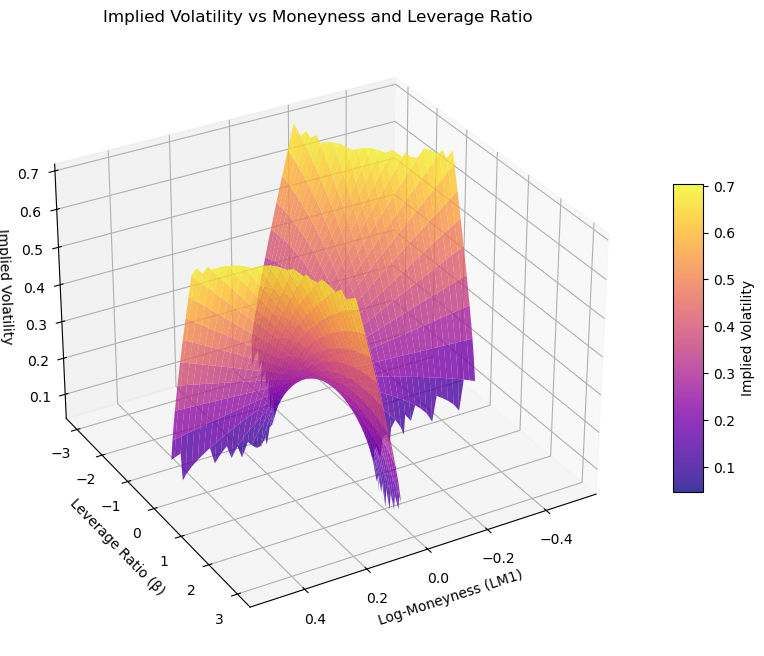

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Parameters
r = 0.03  # Risk-free rate
c = 0.01  # Expense fee
sigma_ref = 0.2  # Volatility of the reference index
T = 1.0  # Time to maturity
S0 = 100  # Initial price of the reference index
n_steps = 252  # Number of time steps (daily rebalancing)
n_simulations = 1000  # Number of simulations

# Simulate paths for the reference index
np.random.seed(42)
dt = T / n_steps
X = np.zeros((n_steps + 1, n_simulations))
X[0] = S0
for t in range(1, n_steps + 1):
    dW = np.random.normal(0, np.sqrt(dt), n_simulations)
    X[t] = X[t - 1] * (1 + r * dt + sigma_ref * dW)

# Function for Black-Scholes implied volatility
def black_scholes_implied_vol(S, K, T, r, c, price, option_type):
    tol = 1e-6
    max_iter = 100
    sigma = 0.2  # Initial guess
    for _ in range(max_iter):
        if sigma < 1e-6 or sigma > 10:
            return np.nan  # Return NaN for invalid sigma values
        d1 = (np.log(S / K) + (r - c + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == "call":
            bs_price = S * np.exp(-c * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == "put":
            bs_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-c * T) * norm.cdf(-d1)
        else:
            raise ValueError("Option type must be 'call' or 'put'")
        vega = S * np.exp(-c * T) * np.sqrt(T) * norm.pdf(d1)
        if abs(vega) < 1e-6:
            return np.nan  # Avoid division by zero
        diff = price - bs_price
        if abs(diff) < tol:
            return sigma
        sigma += diff / vega
    return np.nan

# Function for moneyness scaling
def moneyness_scaling(beta, LM1, sigma_ref):
    return beta * LM1 - (r * (beta - 1) + c) * T - (beta * (beta - 1) / 2) * sigma_ref**2 * T

# Parameters for 3D plot
betas = np.linspace(-3, 3, 100)  # Leverage ratios (continuous and finer range)
LM1 = np.linspace(-0.5, 0.5, 100)  # Log-moneyness (continuous and finer range)
sigma_ref = 0.2  # Volatility of the reference index

# Compute implied volatilities for different beta and LM1
I_beta = np.zeros((len(betas), len(LM1)))
for i, beta in enumerate(betas):
    for j, lm1 in enumerate(LM1):
        LM_beta = moneyness_scaling(beta, lm1, sigma_ref)
        K_beta = S0 * np.exp(LM_beta)  # Strike price for the LETF
        price = K_beta * 0.1  # Example price
        I_beta[i, j] = black_scholes_implied_vol(S0, K_beta, T, r, c, price, "call")

# 3D plot: Moneyness, Leverage Ratio, Implied Volatility
X_grid, Y_grid = np.meshgrid(LM1, betas)  # X_grid: LM1, Y_grid: betas
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X_grid, Y_grid, I_beta, cmap='plasma', edgecolor='none', alpha=0.8)

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Implied Volatility')

# Labels and title
ax.set_xlabel('Log-Moneyness (LM1)', fontsize=10)
ax.set_ylabel('Leverage Ratio (β)', fontsize=10)
ax.set_zlabel('Implied Volatility', fontsize=10)
ax.set_title('Implied Volatility vs Moneyness and Leverage Ratio', fontsize=12)

# Adjust viewing angle
ax.view_init(30, 60)  # Elevation and azimuth angles

# Show plot
plt.show()


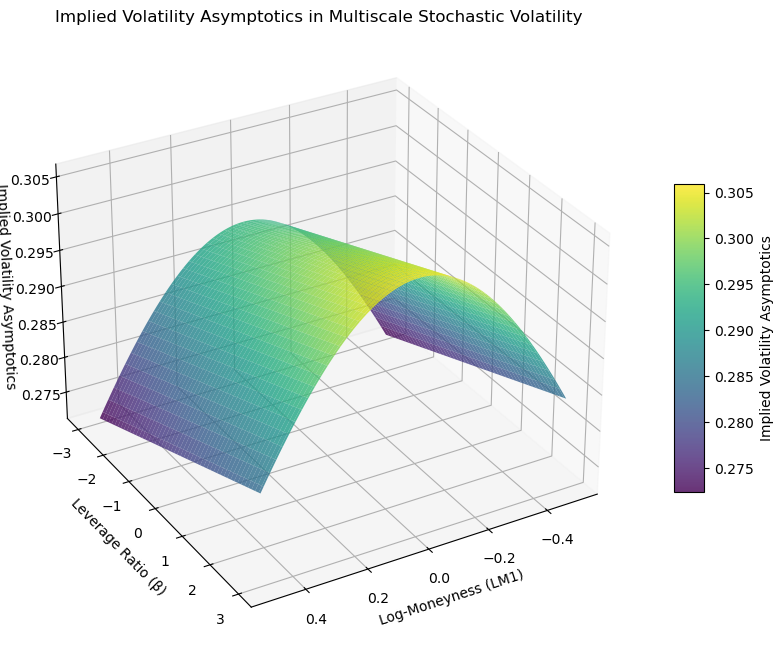

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function for moneyness scaling
def moneyness_scaling(beta, LM1, sigma_ref):
    return beta * LM1 - (r * (beta - 1) + c) * T - (beta * (beta - 1) / 2) * sigma_ref**2 * T

# Function for multiscale implied volatility asymptotics
def implied_vol_asymptotics(beta, LM1, sigma_ref, epsilon=0.1, delta=0.01):
    """
    Simplified multiscale implied volatility asymptotics.
    epsilon: fast-scale volatility parameter.
    delta: slow-scale volatility parameter.
    """
    # Example approximation formula (replace with actual asymptotic expansion)
    sigma_0 = sigma_ref * (1 + delta * beta)  # Slow-scale effect
    sigma_1 = epsilon * np.exp(-LM1**2)  # Fast-scale effect
    sigma_implied = sigma_0 + sigma_1
    return sigma_implied

# Parameters for 3D plot
betas = np.linspace(-3, 3, 100)  # Leverage ratios (continuous and finer range)
LM1 = np.linspace(-0.5, 0.5, 100)  # Log-moneyness (continuous and finer range)
sigma_ref = 0.2  # Volatility of the reference index

# Compute implied volatility asymptotics for different beta and LM1
I_beta = np.zeros((len(betas), len(LM1)))
for i, beta in enumerate(betas):
    for j, lm1 in enumerate(LM1):
        LM_beta = moneyness_scaling(beta, lm1, sigma_ref)
        I_beta[i, j] = implied_vol_asymptotics(beta, lm1, sigma_ref)

# 3D plot: Moneyness, Leverage Ratio, Implied Volatility Asymptotics
X_grid, Y_grid = np.meshgrid(LM1, betas)  # X_grid: LM1, Y_grid: betas
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X_grid, Y_grid, I_beta, cmap='viridis', edgecolor='none', alpha=0.8)

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Implied Volatility Asymptotics')

# Labels and title
ax.set_xlabel('Log-Moneyness (LM1)', fontsize=10)
ax.set_ylabel('Leverage Ratio (β)', fontsize=10)
ax.set_zlabel('Implied Volatility Asymptotics', fontsize=10)
ax.set_title('Implied Volatility Asymptotics in Multiscale Stochastic Volatility', fontsize=12)

# Adjust viewing angle
ax.view_init(30, 60)  # Elevation and azimuth angles

# Show plot
plt.show()


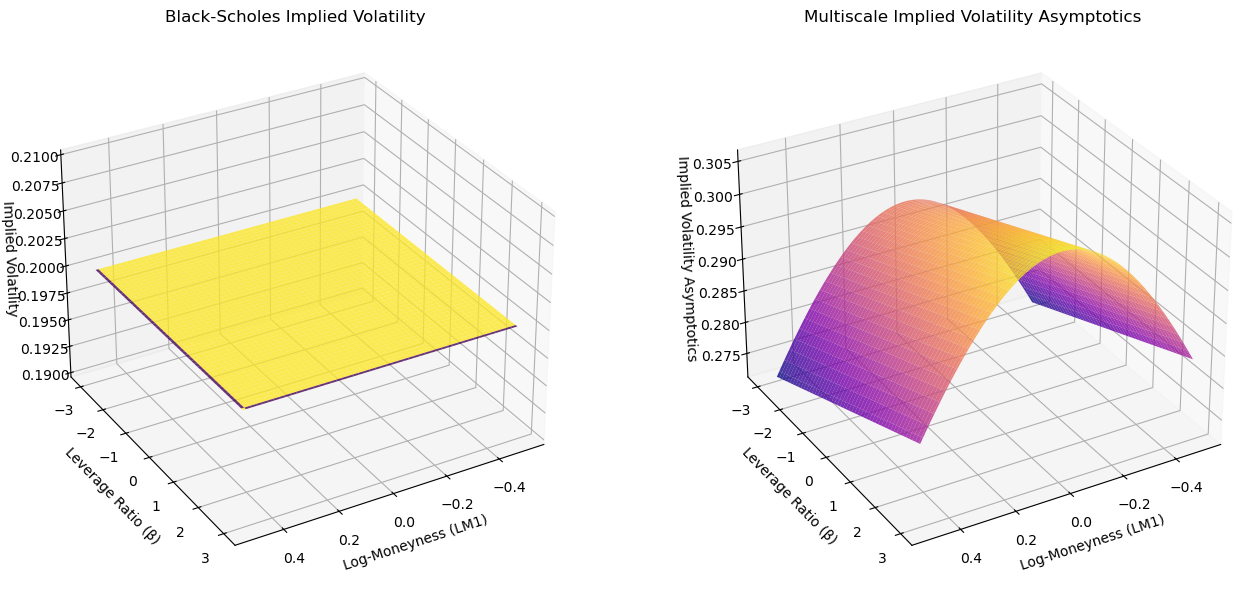

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function for moneyness scaling
def moneyness_scaling(beta, LM1, sigma_ref):
    return beta * LM1 - (r * (beta - 1) + c) * T - (beta * (beta - 1) / 2) * sigma_ref**2 * T

# Function for Black-Scholes implied volatility
def black_scholes_implied_vol(beta, LM1, sigma_ref):
    return sigma_ref * np.ones_like(LM1)  # Constant volatility in Black-Scholes

# Function for multiscale implied volatility asymptotics
def implied_vol_asymptotics(beta, LM1, sigma_ref, epsilon=0.1, delta=0.01):
    """
    Simplified multiscale implied volatility asymptotics.
    epsilon: fast-scale volatility parameter.
    delta: slow-scale volatility parameter.
    """
    sigma_0 = sigma_ref * (1 + delta * beta)  # Slow-scale effect
    sigma_1 = epsilon * np.exp(-LM1**2)  # Fast-scale effect
    sigma_implied = sigma_0 + sigma_1
    return sigma_implied

# Parameters for 3D plot
betas = np.linspace(-3, 3, 100)  # Leverage ratios
LM1 = np.linspace(-0.5, 0.5, 100)  # Log-moneyness
sigma_ref = 0.2  # Volatility of the reference index

# Create grid for plotting
X_grid, Y_grid = np.meshgrid(LM1, betas)

# Compute implied volatilities
I_bs = np.zeros_like(X_grid)  # Black-Scholes
I_ms = np.zeros_like(X_grid)  # Multiscale
for i, beta in enumerate(betas):
    for j, lm1 in enumerate(LM1):
        I_bs[i, j] = black_scholes_implied_vol(beta, lm1, sigma_ref)
        I_ms[i, j] = implied_vol_asymptotics(beta, lm1, sigma_ref)

# 3D plot for comparison
fig = plt.figure(figsize=(14, 6))

# Plot Black-Scholes implied volatility
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X_grid, Y_grid, I_bs, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('Log-Moneyness (LM1)')
ax1.set_ylabel('Leverage Ratio (β)')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Black-Scholes Implied Volatility')

# Plot multiscale implied volatility asymptotics
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X_grid, Y_grid, I_ms, cmap='plasma', edgecolor='none', alpha=0.8)
ax2.set_xlabel('Log-Moneyness (LM1)')
ax2.set_ylabel('Leverage Ratio (β)')
ax2.set_zlabel('Implied Volatility Asymptotics')
ax2.set_title('Multiscale Implied Volatility Asymptotics')

# Adjust viewing angles
ax1.view_init(30, 60)
ax2.view_init(30, 60)

# Show plots
plt.tight_layout()
plt.show()


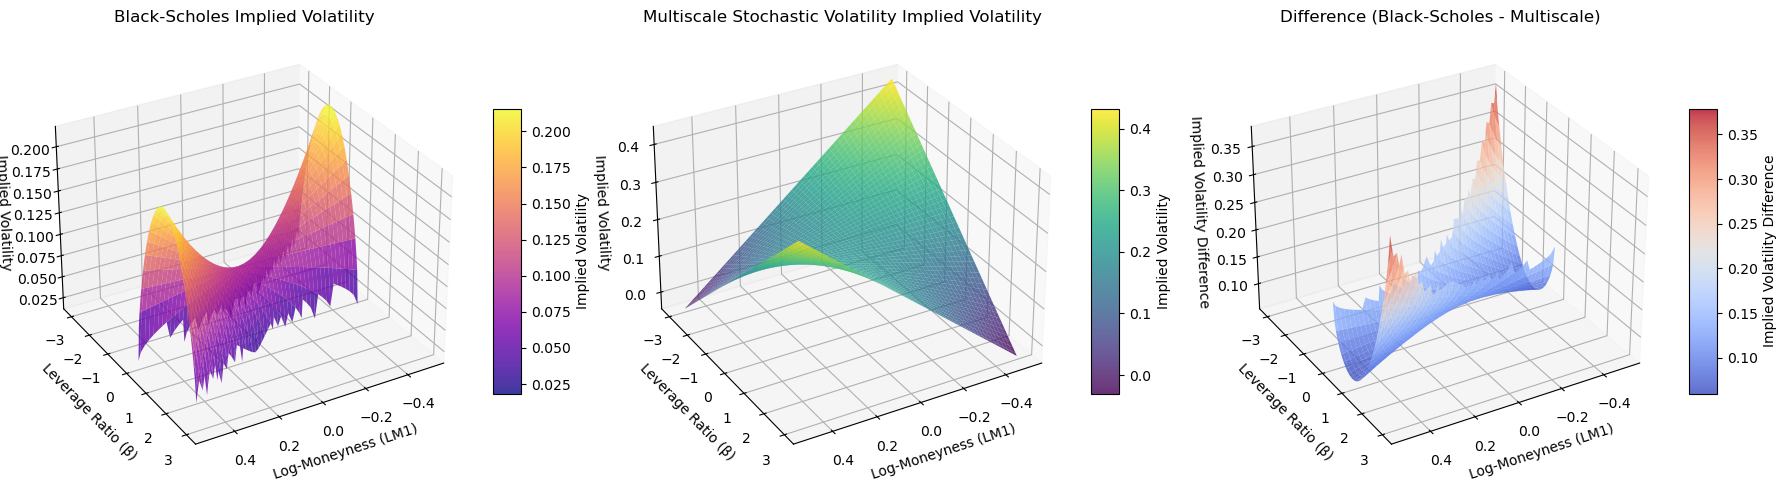

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Parameters
r = 0.02  # Risk-free rate
c = 0.01  # Expense fee
sigma_ref = 0.5  # Volatility of the reference index
T = 10.0  # Time to maturity
S0 = 100  # Initial price of the reference index
n_steps = 252  # Number of time steps (daily rebalancing)
n_simulations = 5000  # Number of simulations

# Simulate paths for the reference index
np.random.seed(42)
dt = T / n_steps
X = np.zeros((n_steps + 1, n_simulations))
X[0] = S0
for t in range(1, n_steps + 1):
    dW = np.random.normal(0, np.sqrt(dt), n_simulations)
    X[t] = X[t - 1] * (1 + r * dt + sigma_ref * dW)

# Function for Black-Scholes implied volatility
def black_scholes_implied_vol(S, K, T, r, c, price, option_type):
    tol = 1e-6
    max_iter = 100
    sigma = 0.2  # Initial guess
    for _ in range(max_iter):
        if sigma < 1e-6 or sigma > 10:
            return np.nan  # Return NaN for invalid sigma values
        d1 = (np.log(S / K) + (r - c + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == "call":
            bs_price = S * np.exp(-c * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == "put":
            bs_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-c * T) * norm.cdf(-d1)
        else:
            raise ValueError("Option type must be 'call' or 'put'")
        vega = S * np.exp(-c * T) * np.sqrt(T) * norm.pdf(d1)
        if abs(vega) < 1e-6:
            return np.nan  # Avoid division by zero
        diff = price - bs_price
        if abs(diff) < tol:
            return sigma
        sigma += diff / vega
    return np.nan

# Function for implied volatility under multiscale stochastic volatility model (example asymptotics)
def multiscale_implied_vol(beta, LM1, sigma_ref, T):
    # Example formula for multiscale stochastic volatility model (replace with actual asymptotics)
    return sigma_ref * (1 + beta * LM1 / (2 * sigma_ref * np.sqrt(T)))

# Function for moneyness scaling
def moneyness_scaling(beta, LM1, sigma_ref):
    return beta * LM1 - (r * (beta - 1) + c) * T - (beta * (beta - 1) / 2) * sigma_ref**2 * T

# Parameters for 3D plot
betas = np.linspace(-3, 3, 100)  # Leverage ratios (continuous and finer range)
LM1 = np.linspace(-0.5, 0.5, 100)  # Log-moneyness (continuous and finer range)
sigma_ref = 0.2  # Volatility of the reference index

# Compute implied volatilities for different beta and LM1 (Black-Scholes)
I_beta_bs = np.zeros((len(betas), len(LM1)))
for i, beta in enumerate(betas):
    for j, lm1 in enumerate(LM1):
        LM_beta = moneyness_scaling(beta, lm1, sigma_ref)
        K_beta = S0 * np.exp(LM_beta)  # Strike price for the LETF
        price = K_beta * 0.1  # Example price
        I_beta_bs[i, j] = black_scholes_implied_vol(S0, K_beta, T, r, c, price, "call")

# Compute implied volatilities for different beta and LM1 (Multiscale Stochastic Volatility)
I_beta_ms = np.zeros((len(betas), len(LM1)))
for i, beta in enumerate(betas):
    for j, lm1 in enumerate(LM1):
        I_beta_ms[i, j] = multiscale_implied_vol(beta, lm1, sigma_ref, T)

# 3D plot: Black-Scholes Implied Volatility
X_grid, Y_grid = np.meshgrid(LM1, betas)  # X_grid: LM1, Y_grid: betas
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X_grid, Y_grid, I_beta_bs, cmap='plasma', edgecolor='none', alpha=0.8)
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('Implied Volatility')
ax1.set_xlabel('Log-Moneyness (LM1)', fontsize=10)
ax1.set_ylabel('Leverage Ratio (β)', fontsize=10)
ax1.set_zlabel('Implied Volatility', fontsize=10)
ax1.set_title('Black-Scholes Implied Volatility', fontsize=12)
ax1.view_init(30, 60)

# 3D plot: Multiscale Stochastic Volatility Implied Volatility
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X_grid, Y_grid, I_beta_ms, cmap='viridis', edgecolor='none', alpha=0.8)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('Implied Volatility')
ax2.set_xlabel('Log-Moneyness (LM1)', fontsize=10)
ax2.set_ylabel('Leverage Ratio (β)', fontsize=10)
ax2.set_zlabel('Implied Volatility', fontsize=10)
ax2.set_title('Multiscale Stochastic Volatility Implied Volatility', fontsize=12)
ax2.view_init(30, 60)

# 3D plot: Difference between Black-Scholes and Multiscale Stochastic Volatility Implied Volatility
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X_grid, Y_grid, I_beta_ms - I_beta_bs, cmap='coolwarm', edgecolor='none', alpha=0.8)
cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
cbar3.set_label('Implied Volatility Difference')
ax3.set_xlabel('Log-Moneyness (LM1)', fontsize=10)
ax3.set_ylabel('Leverage Ratio (β)', fontsize=10)
ax3.set_zlabel('Implied Volatility Difference', fontsize=10)
ax3.set_title('Difference (Black-Scholes - Multiscale)', fontsize=12)
ax3.view_init(30, 60)

plt.tight_layout()
plt.show()
